# Radon model with pymc3


In [1]:
import toyplot
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az

### Load data

In [2]:
# load the radon dataset 
data = pd.read_csv(pm.get_data("radon.csv"))

# set a unique number for each county
data['code'] = pd.factorize(data.county)[0]

# convert floor to int type
data['floor'] = data.floor.astype(int)

# select only relevant columns
data = data.loc[:, ["county", "code", "floor", "log_radon"]]

# show some random rows
data.sample(10).reset_index(drop=True)

,county,code,floor,log_radon
0,STEVENS,72,0,1.526056
1,RICE,63,0,1.547563
2,HENNEPIN,25,0,1.722767
3,ROSEAU,65,1,1.808289
4,ST LOUIS,69,0,0.405465
5,BLUE EARTH,6,0,1.945910
6,ANOKA,1,1,0.641854
7,OLMSTED,53,0,0.741937
8,DAKOTA,18,0,0.530628
9,CLAY,13,1,1.280934


### Visualize data

In [3]:
# show histogram of all radon measurements
c, a, m = toyplot.bars(
    np.histogram(data.log_radon, bins=25),
    height=250,
    width=350,
    xlabel="log radon measurement"
)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="250.0px" viewBox="0 0 350.0 250.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t6231b38b6e1d44aaa92155eef3f056d7"> -2 0 2 4 log radon measurement 0 50 100 150

### Define a function for plotting posterior trace later on

In [4]:
def toytrace(trace, var_names):
    """
    Plot posterior trace with toyplot
    """
    nvars = len(var_names)
    
    # setup canvase
    canvas = toyplot.Canvas(width=500, height=200 * nvars)
    
    # iter over params
    for pidx, param in enumerate(var_names):
        
        # get param posterior
        posterior = trace.get_values(param)
        
        # setup axes 
        axes = canvas.cartesian(grid=(nvars, 1, pidx))
        axes.y.show = False
        axes.x.spine.style = {"stroke-width": 1.5}
        axes.x.ticks.labels.style = {"font-size": "12px"}
        axes.x.ticks.show = True
        axes.x.label.text = f"param='{param}'"        
        
        # iterate over shape of param
        for idx in range(posterior.shape[1]):
            mags, bins = np.histogram(posterior[:, idx], bins=100)
            axes.plot(bins[1:], mags, stroke_width=2, opacity=0.6)
    return canvas

<h2><i>Fit <span style="color:red">pooled</span> model</i></h2>

Treat all counties the same, and estimate a single radon level.

$$ \text{radon}_{i,c} = \alpha + \beta * \text{floor}_{i,c} + \epsilon_i $$

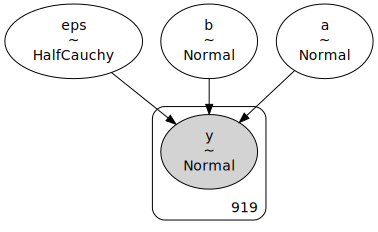

In [5]:
with pm.Model() as pooled:  
    
    # parameters and error
    a = pm.Normal('a', mu=0, sigma=10, shape=1)
    b = pm.Normal('b', mu=0, sigma=5, shape=1)
    eps = pm.HalfCauchy('eps', 5.0)
    
    # model prediction
    radon = a + b * data.floor.values
    
    # data likelihood
    y = pm.Normal("y", mu=radon, sigma=eps, observed=data.log_radon)

# visualize model graph
pm.model_to_graphviz(pooled)

In [6]:
with pooled:
    # sample posterior
    trace_pooled = pm.sample(
        tune=5000,
        draws=5000,
        target_accept=0.9,
        return_inferencedata=False, 
        progressbar=False,
    )
    
    # show summary table
    stats = az.summary(trace_pooled, kind="stats")
    display(stats)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 8 seconds.


,mean,sd,hdi_3%,hdi_97%
a[0],1.362,0.029,1.307,1.414
b[0],-0.586,0.071,-0.720,-0.454
eps,0.791,0.019,0.756,0.826


In [7]:
toytrace(trace_pooled, ['a', 'b']);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="400.0px" viewBox="0 0 500.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tbe4511a7f08f490bbe30c079583416af"> <path d="M 50.794123654955925 149.85528219971056 L 54.619484217124636 150.0 L 58.44484477929335 150.0 L 62.27020534146206 149.71056439942114 L 66.09556590363077 150.0 L 69.92092646579948 149.71056439942114 L 73.7462870279682 149.85528219971056 L 77.5716475901369 149.85528219971056 L 81.39700815230562 149.4211287988423 L 85.22236871447433 149.4211287988423 L 89.04772927664304 149.71056439942114 L 92.87308983881175 149.13169319826338 L 96.69845040098046 149.13169319826338 L 100.52381096314917 147.9739507959479 L 104.34917152531789 147.39507959479016 L 108.1745320874866 147.82923299565846 L 111.99989264965495 145.9479015918958 L 115.82525321182366 147.25036179450072 L 119.65061377399238 145.9479015918958 L 123.4759743361611 144.79015918958032 L 127.3013348983298 141.75108538350216 L 131.1266954604985 142.76410998552822 L 134.95205602266722 139.8697539797395 L 138.77741658483592 137.4095513748191 L 142.60277714700464 135.09406657018812 L 146.42813770917337 132.9232995658466 L 150.25349827134207 127.56874095513749 L 154.0788588335108 123.37192474674386 L 157.9042193956795 122.3589001447178 L 161.7295799578482 123.80607814761214 L 165.55494052001694 115.4124457308249 L 169.3803010821856 108.32127351664255 L 173.20566164435434 106.43994211287988 L 177.03102220652306 100.94066570188134 L 180.85638276869173 98.3357452966715 L 184.68174333086048 96.74384949348769 L 188.50710389302918 86.90303907380607 L 192.3324644551979 82.99565846599131 L 196.1578250173666 77.78581765557163 L 199.98318557953533 76.62807525325616 L 203.80854614170403 63.74819102749639 L 207.63390670387273 69.39218523878436 L 211.45926726604145 63.16931982633865 L 215.28462782821015 61.57742402315485 L 219.10998839037887 58.39363241678726 L 222.93534895254757 54.92040520984081 L 226.7607095147163 58.68306801736613 L 230.586070076885 60.85383502170767 L 234.41143063905372 63.60347322720693 L 238.23679120122245 50.0 L 242.06215176339114 52.894356005788715 L 245.8875123255595 57.23589001447178 L 249.71287288772857 63.16931982633865 L 253.53823344989692 64.76121562952243 L 257.3635940120656 64.90593342981187 L 261.18895457423434 65.91895803183792 L 265.01431513640307 73.87843704775688 L 268.83967569857174 77.49638205499276 L 272.66503626074046 84.29811866859623 L 276.4903968229092 88.06078147612156 L 280.31575738507786 92.11287988422576 L 284.14111794724664 101.08538350217077 L 287.9664785094153 104.1244573082489 L 291.79183907158404 108.9001447178003 L 295.61719963375276 109.62373371924748 L 299.44256019592143 124.67438494934878 L 303.2679207580902 121.78002894356005 L 307.0932813202589 127.85817655571635 L 310.9186418824276 125.25325615050652 L 314.7440024445963 131.47612156295224 L 318.56936300676506 134.51519536903038 L 322.3947235689337 136.10709117221418 L 326.22008413110245 138.42257597684514 L 330.0454446932711 141.31693198263386 L 333.87080525543985 142.32995658465993 L 337.6961658176086 144.06657018813314 L 341.5215263797773 145.51374819102747 L 345.34688694194597 146.09261939218524 L 349.1722475041147 146.23733719247466 L 352.9976080662834 147.68451519536902 L 356.82296862845214 147.82923299565846 L 360.64832919062087 148.55282199710564 L 364.47368975278954 147.68451519536902 L 368.29905031495827 148.98697539797396 L 372.12441087712665 149.4211287988423 L 375.9497714392957 149.27641099855282 L 379.77513200146404 149.27641099855282 L 383.60049256363277 149.56584659913167 L 387.42585312580144 149.85528219971056 L 391.25121368797

<div class='alert alert-info'>
    <b>Interpretation of pooled result:</b> The effect of <i>not</i> having a basement (floor=1) on radon levels is to decrease the level of radon (i.e., basements have more radon) by a slope factor of 0.6.
</div>

<h2><i>Fit <span style="color:red">unpooled</span> model</i></h2>

Treat all counties the same, and estimate a single radon level.

$$ \text{radon}_{i,c} = \alpha_c + \beta_c * \text{floor}_{i,c} + \epsilon_{i_c} $$

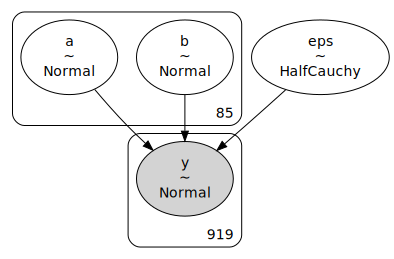

In [8]:
with pm.Model() as unpooled:  
    
    # parameters and error
    a = pm.Normal('a', mu=0, sigma=10, shape=len(data.county.unique()))
    b = pm.Normal('b', mu=0, sigma=5, shape=len(data.county.unique()))
    eps = pm.HalfCauchy('eps', 5.0)
    
    # model prediction
    radon = a[data.code] + b[data.code] * data.floor.values
    
    # data likelihood
    y = pm.Normal("y", mu=radon, sigma=eps, observed=data.log_radon)

# visualize model graph
pm.model_to_graphviz(unpooled)

In [9]:
with unpooled:
    trace_unpooled = pm.sample(
        tune=5000,
        draws=5000,
        target_accept=0.9,
        return_inferencedata=False,
        progressbar=False,
    )
    
    # show summary table
    stats = az.summary(trace_unpooled, kind="stats")
    display(stats)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 37 seconds.


,mean,sd,hdi_3%,hdi_97%
a[0],0.679,0.413,-0.075,1.484
a[1],0.952,0.102,0.763,1.145
a[2],1.463,0.705,0.140,2.777
a[3],1.717,0.412,0.942,2.489
a[4],1.338,0.411,0.596,2.128
...,...,...,...,...
b[81],0.052,4.992,-9.482,9.223
b[82],-1.963,0.471,-2.824,-1.064
b[83],-0.781,0.743,-2.172,0.618
b[84],0.010,5.023,-9.226,9.604


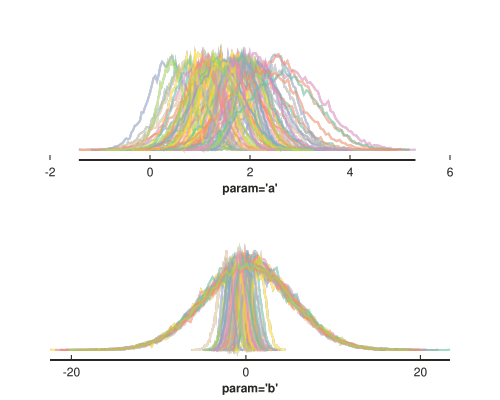

In [10]:
toytrace(trace_unpooled, ['a', 'b'])

<div class='alert alert-info'>
    <b>Interpretation of unpooled result:</b> The effect of <i>not</i> having a basement (floor=1) on radon levels is variable depending on which county you are in. However, many counties have very high variance in these estimates, likely because there is too little data. 
</div>

<h2><i>Fit <span style="color:red">partially-pooled</span> model</i></h2>

Draw a and b parameters from hyperprior distributions.

$$ \alpha_c \sim \mathcal{N}(\mu_\alpha, \sigma^2_\alpha) $$
$$ \beta_c \sim \mathcal{N}(\mu_\alpha, \sigma^2_\beta) $$
$$ \text{radon}_{i,c} = \alpha_c + \beta_c * \text{floor}_{i,c} + \epsilon_{i_c} $$

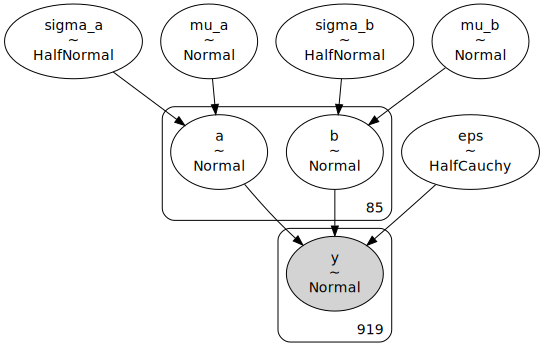

In [11]:
with pm.Model() as hierarchical:  
    
    # hyperparameters
    mu_a = pm.Normal("mu_a", mu=0, sigma=100, shape=1)
    mu_b = pm.Normal("mu_b", mu=0, sigma=100, shape=1)
    sigma_a = pm.HalfNormal("sigma_a", 5.0, shape=1)
    sigma_b = pm.HalfNormal("sigma_b", 5.0, shape=1)

    # parameters and error
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=len(data.county.unique()))
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=len(data.county.unique()))
    eps = pm.HalfCauchy('eps', 5.0)
    
    # model prediction
    radon = a[data.code] + b[data.code] * data.floor.values
    
    # data likelihood
    y = pm.Normal("y", mu=radon, sigma=eps, observed=data.log_radon)

# visualize model graph
pm.model_to_graphviz(hierarchical)

In [12]:
with hierarchical:
    trace_hierarchical = pm.sample(
        tune=5000,
        draws=5000,
        target_accept=0.9,
        return_inferencedata=False,
        progressbar=False,
    )
    
    # show summary table
    stats = az.summary(trace_hierarchical, kind="stats")
    display(stats)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, sigma_a, mu_b, mu_a]
Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 78 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.813307355552557, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hdi_3%,hdi_97%
mu_a[0],1.490,0.052,1.394,1.588
mu_b[0],-0.645,0.086,-0.810,-0.487
a[0],1.211,0.245,0.748,1.672
a[1],0.988,0.097,0.817,1.180
a[2],1.503,0.269,1.004,2.024
...,...,...,...,...
b[83],-0.661,0.283,-1.209,-0.103
b[84],-0.641,0.316,-1.261,-0.038
sigma_a[0],0.325,0.046,0.241,0.410
sigma_b[0],0.284,0.115,0.061,0.469


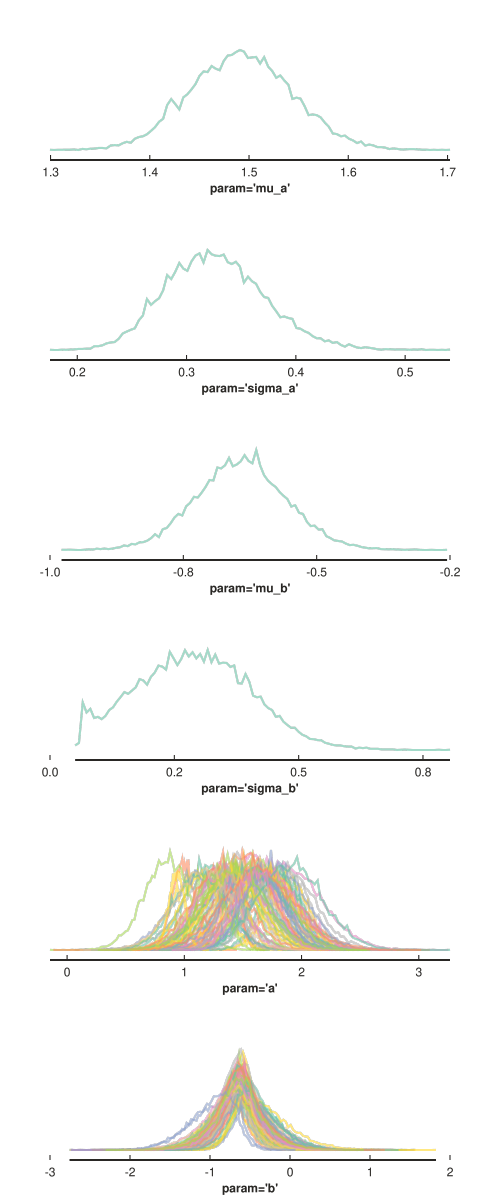

In [13]:
toytrace(
    trace=trace_hierarchical, 
    var_names=['mu_a', 'sigma_a', 'mu_b', 'sigma_b', 'a', 'b'],
)

<div class='alert alert-info'>
    <b>Interpretation of partially-pooled (hierarchical) result:</b> We can see from <code>mu_a</code> and <code>sigma_a</code> that the mean log radon level across the <i>group</i> of counties is approximately 1.5 $\pm$ 0.3. And we can see from <code>mu_b</code> and <code>sigma_b</code> that the effect of having no basement (floor=1) is to decrease log radon levels by a factor of approximately -0.7 $\pm$ 0.2.
<br><br>
In addition, we can see from looking at the <code>a</code> values that the amount of radon varies considerably across counties, with some having nearly 2X higher means than others. But, the effect of having a basement (<code>b</code>) in each county is pretty uniform. Comparing this to the result of the unpooled model, it is clear that pooling had a large effect on the <code>b</code> parameter posterior estimates, brining the estimates of the outliers closer to the means of the other counties that had much more data.
</div>

## Model comparison

The arviz package can be used for Bayesian model comparison using the leave-one-out (loo) method. 

... I'm not sure why we cannot include "pooled" model in this test...

In [14]:
with hierarchical:
    with unpooled:
        mod_compare = az.compare(
            dataset_dict={
                "hierarchical": trace_hierarchical,
                "unpooled": trace_unpooled,
            },
        )

/home/deren/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/deren/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/deren/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior

In [15]:
mod_compare.T

,hierarchical,unpooled
rank,0,1
loo,-1039.26,-1100.56
p_loo,67.5764,152.551
d_loo,0,61.291
weight,0.989109,0.0108909
se,28.8897,30.7197
dse,0,10.9098
warning,True,True
loo_scale,log,log


<div class='alert alert-info'>
    <b>Interpretation of model comparison:</b> See the arviz documentation for further description of the 'LOO' method. The lower ranked model is the better fit to the data. The weight here tells us the relative confidence we should have in either model. Clearly the hierarchical model is a much better fit to the data in this case.        
</div>

## Resources

- [pymc3 hierarchical models](https://docs.pymc.io/pymc-examples/examples/generalized_linear_models/GLM-hierarchical.html)
- [arviz model comparison](https://docs.pymc.io/notebooks/model_comparison.html)